# Определение неэффективных операторов

**Заказчик:** продуктовый менеджер отдела продуктовой разработки провайдера "Нупозвони".

"Нупозвони" - провайдер виртуальной телефонии. Клиентами провайдера являются колл-центры, которые распределеяют входящие вызовы на операторов (техподдержка, горячая линия и т.п.) или совершают исходящие вызовы силами операторов (маркетинг, соцопросы и т.п.). Также операторы колл-центров могут совершать внутренние звонки между собой внутри сети виртуальной телефонии.

**Запрос заказчика:** Заказчик хочет разработать программу для определения неэффективных операторов. Программу планируется продавать колл-центрам. Перед этим заказчик хочет прощупать почву - определить, насколько эта услуга будет востребована и каким колл-центрам можно её предложить.

**Цель исследования:** провести исследовательский анализ данных, выявить потенциальных клиентов новой услуги по определению неэффективных операторов.

Признаки неэффективности операторов колл-центров:
- много пропущенных входящих звонков;
- долгое ожидание ответа при входящих вызовах;
- мало исходящих звонков - для колл-центров, специализирующихся на обзвонах.

**План исследования:**
- Изучение общей информации о данных.
- Обработка данных: устранение дубликатов, работа с пропусками и типами данных, добавление новых столбцов (столбец с временем ожидания).
- Определить временной период данных - найти минимальную и максимальную даты.
- Разделение колл-центров на обзванивающие и принимающие. Для этого необходимо сгруппировать данные по id клиентов и посчитать количество входящих и исходящих звонков (либо их процент от общего кличества вызовов).
- Провести исследовательский анализ данных о количестве пропущенных, исходящих, входящих звонках, длительности вызова и времени ожидания.
- Определить пороги эффективности - количество пропущенных звонков, длительность ожидания ответа и количество исходящих вызовов, при которых оператора можно считать неэффективным.
- Сформировать список колл-центров с большим количеством неэффективных сотрудников.
- Сформировать нулевые и альтернативные статистические гипотезы и проверить их.
- Сделать выводы, дать рекомендации заказчику.
- Подготовить перезнтацию после создания дашборда.

## Общая информация о данных

Перед исследованием необходимо загрузить необходимые билиотеки и ознакомиться с данными.

In [1]:
# импорт необходимых библиотек
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import warnings; warnings.filterwarnings(action = 'ignore')

In [2]:
# загрузка данных
try:
    data = pd.read_csv('telecom_dataset.csv')
    clients = pd.read_csv('telecom_clients.csv')
except:
    data = pd.read_csv('/datasets/telecom_dataset.csv')
    clients = pd.read_csv('/datasets/telecom_clients.csv')

### Журнал звонков

In [3]:
data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


Столбцы в `data` (журнале звонков):

- `user_id` — Идентификатор клиентского аккаунта колл-центра в сервисе
- `date` — Дата статистики
- `direction` — Направление вызовов (out - исходящий вызов, in — входящий вызов)
- `internal` — Является ли звонок внутренним звонком между операторами клиента
- `operator_id` — Идентификатор оператора
- `is_missed_call` — Является ли звонок пропущенным (для входящих) и непринятым (для исходящих), длительность таких звонков без времени ожидания равна нулю
- `calls_count` — Количество звонков с определёнными характеристиками (например, входящий и пропущенный, исходящий и принятый) для каждого оператора за конкретный день
- `call_duration` — Длительность звонка (без учета времени ожидания)
- `total_call_duration` — Длительность звонка (с учетом времени ожидания).

В датасете присутствуют пропуски с столбцах `internal` и `operator_id`. Также неверный тип данных в столбцах `date` и `internal` (из-за наличия пропусков).

### Профили клиентов

In [5]:
clients.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


In [6]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


Столбцы в `clients` (профилях клиентов):
- `user_id` — Идентификатор клиентского аккаунта в сервисе
- `tariff_plan` — Текущий тарифный план клиента
- `date_start` — Дата регистрации клиентв в сервисе

В датасете нет пропусков, но у столбца `date_start` неверный тип данных.

## Предобработка данных

Для дальнейшей работы с данными необходимо выполнить предобработку - обработать имеющиеся пропуски, дубликаты, заменить типы данных там, где это необходимо, создать новый столбец.

### Обработка дубликатов

In [7]:
print('Количество явных дубликатов в data: {}'.format(data.duplicated().sum()))
print('Процент явных дубликатов в data: {}%'.format(round(data.duplicated().sum() / data.shape[0] * 100, 1)))
print()
print('Количество явных дубликатов в clients: {}'.format(clients.duplicated().sum()))
print('Процент явных дубликатов в clients: {}%'.format(round(clients.duplicated().sum() / clients.shape[0] * 100, 1)))

Количество явных дубликатов в data: 4900
Процент явных дубликатов в data: 9.1%

Количество явных дубликатов в clients: 0
Процент явных дубликатов в clients: 0.0%


Удалим из датасета `data` 4900 явных дубикатов (9.1% от всех данных).

In [8]:
data = data.drop_duplicates()
# проверка
print('Количество явных дубликатов в data: {}'.format(data.duplicated().sum()))
print('Процент явных дубликатов в data: {}%'.format(round(data.duplicated().sum() / data.shape[0] * 100, 1)))

Количество явных дубликатов в data: 0
Процент явных дубликатов в data: 0.0%


### Обработка пропусков

Составим таблицу с количеством пропусков в каждом столбце `data` и процентом пропусков от общего количества строк.

In [9]:
data_isna = pd.DataFrame(data.isna().sum())
data_isna.columns = ['isna']
data_isna['isna_perc'] = round(data_isna['isna'] / data.shape[0] * 100, 1)
data_isna

,isna,isna_perc
user_id,0,0.0
date,0,0.0
direction,0,0.0
internal,110,0.2
operator_id,7456,15.2
is_missed_call,0,0.0
calls_count,0,0.0
call_duration,0,0.0
total_call_duration,0,0.0


Присутствует большое количество пропусков в столбце `operator_id` (15.2%) и 0.2% пропусков в столбце `internal`.

Попробуем исследовать природу пропусков в `operator_id`.

In [10]:
(
    data
    .loc[data['operator_id'].isna()]
    .groupby(['direction', 'internal', 'is_missed_call'])
    .agg({'user_id': 'count'})
    .sort_values('user_id', ascending=False)
)

user_id
direction internal is_missed_call         
in        False    True               6870
          True     True                279
out       False    True                108
in        False    False                62
out       False    False                38
          True     True                 31
                   False                 7
in        True     False                 6

Большая часть пропусков в `oparator_id` - это внешние входящие пропущенные звонки. Можно предположить, что это входящие звонки, при которых абоненты не дождались ответа и сбросили звонок. Скорее всего звонок не был направлен на конкретного оператора, поэтому присутствует пропуск. Остальные пропуски - ошибки в записи данных.

Попробуем исследовать природу пропусков в `internal`.

In [11]:
(
    data
    .loc[data['internal'].isna()]
    .groupby(['direction', 'is_missed_call'])
    .agg({'user_id': 'count'})
    .sort_values('user_id', ascending=False)
)

user_id
direction is_missed_call         
in        False                54
          True                 54
out       True                  2

В основном это входящие звонки, половина из которых пропущены. Возможно, произошла ошибка в фиксации номера абонента, совершающего звонок. Вероятнее всего это были внешние звонки.

Заменим пропуски в столбце `operator_id` на значение 1, а пропуски в столбце `internal` в количестве 110 штук удалим.

In [12]:
data['operator_id'] = data['operator_id'].fillna(1)
data = data.dropna()
# проверка
data_isna = pd.DataFrame(data.isna().sum())
data_isna.columns = ['isna']
data_isna['isna_perc'] = round(data_isna['isna'] / data.shape[0] * 100, 1)
data_isna

,isna,isna_perc
user_id,0,0.0
date,0,0.0
direction,0,0.0
internal,0,0.0
operator_id,0,0.0
is_missed_call,0,0.0
calls_count,0,0.0
call_duration,0,0.0
total_call_duration,0,0.0


In [13]:
data.shape

(48892, 9)

Рассмотрим пропуски в `clients`.

In [14]:
clients_isna = pd.DataFrame(clients.isna().sum())
clients_isna.columns = ['isna']
clients_isna['isna_perc'] = round(clients_isna['isna'] / clients.shape[0] * 100, 1)
clients_isna

,isna,isna_perc
user_id,0,0.0
tariff_plan,0,0.0
date_start,0,0.0


В `clients` пропуски отсутствуют.

**Вывод:** 

В столбце `operator_id` бОльшая часть пропусков - внешние входящие пропущенные звонки. Вероятнее всего такие звонки не были направлены на конкретных операторов, поэтому образовались пропуски. Заполнили пропуски значением 1.

В столбце `internal` бОльшая часть пропусков - входящие вызовы. Есть предположение, что это были внешние вызовы, при которых произошла ошибка фиксации номера звонившего абонента (например, скрытый номер). Удалили пропуски.


В `clients` пропуски отсутствуют.

### Типы данных

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48892 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              48892 non-null  int64  
 1   date                 48892 non-null  object 
 2   direction            48892 non-null  object 
 3   internal             48892 non-null  object 
 4   operator_id          48892 non-null  float64
 5   is_missed_call       48892 non-null  bool   
 6   calls_count          48892 non-null  int64  
 7   call_duration        48892 non-null  int64  
 8   total_call_duration  48892 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.4+ MB


Необходимо привести данные столбца `date` к типу данных `datetime` и оставить только дату, а также данные столбца `internal` к типу `bool` и данные столбца `operator_id` к типу `int`.

In [16]:
data['date'] = pd.to_datetime(pd.to_datetime(data['date']).dt.date)
data['internal'] = data['internal'].astype(bool)
data['operator_id'] = data['operator_id'].astype('int')
# проверка
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48892 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              48892 non-null  int64         
 1   date                 48892 non-null  datetime64[ns]
 2   direction            48892 non-null  object        
 3   internal             48892 non-null  bool          
 4   operator_id          48892 non-null  int32         
 5   is_missed_call       48892 non-null  bool          
 6   calls_count          48892 non-null  int64         
 7   call_duration        48892 non-null  int64         
 8   total_call_duration  48892 non-null  int64         
dtypes: bool(2), datetime64[ns](1), int32(1), int64(4), object(1)
memory usage: 2.9+ MB


In [17]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


Изменим тип данных столбца `date_start` на `datetime`.

In [18]:
clients['date_start'] = pd.to_datetime(pd.to_datetime(clients['date_start']).dt.date)
# проверка
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      732 non-null    int64         
 1   tariff_plan  732 non-null    object        
 2   date_start   732 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 17.3+ KB


### Время ожидания

Для дальнейшего исследования и определения порогов критериев эффективности необходимо создать столбец с временем ожидания.

In [19]:
data['waiting'] = data['total_call_duration'] - data['call_duration']
# проверка
data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting
0,166377,2019-08-04,in,False,1,True,2,0,4,4
1,166377,2019-08-05,out,True,880022,True,3,0,5,5
2,166377,2019-08-05,out,True,880020,True,1,0,1,1
3,166377,2019-08-05,out,True,880020,False,1,10,18,8
4,166377,2019-08-05,out,False,880022,True,3,0,25,25


**Вывод:** Проведена предобработка данных:
- удалены явные дубликаты
- удалили 0.2% пропусков в `internal`
- пропуски в `operator_id` заполнили 1
- изменили типы данных, где необходимо
- создан столбец с временем ожидания.

Данные готовы к дальнейшему исследованию.

## Исследовательский анализ

### Временной период

Определим период, за который имеются данные в `data`. Для этого найдём минимальную и максимальную даты в столбце `date`.

In [20]:
print('Период данных: с {} по {}'.format(data['date'].dt.date.min(), data['date'].dt.date.max()))

Период данных: с 2019-08-02 по 2019-11-28


**Вывод:** Итого у нас имеются данные за 4 неполных месяца со 2 августа по 28 ноября 2019 года.

### Длительность вызовов и единицы измерения

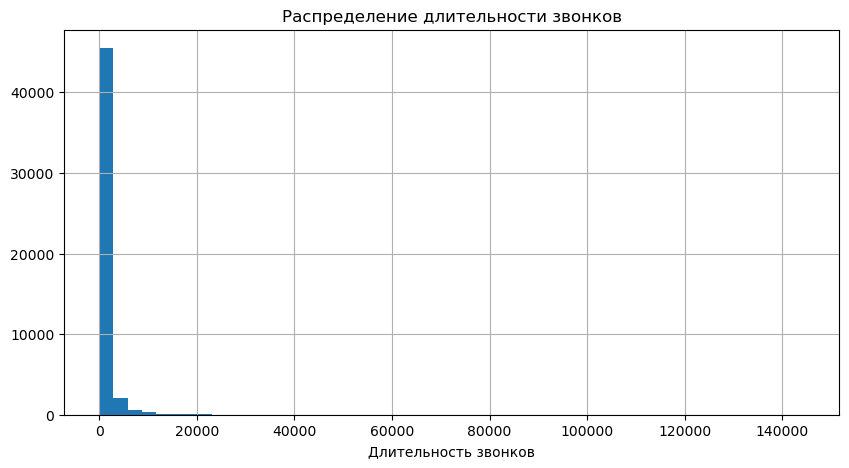

In [21]:
data['call_duration'].hist(bins=50, figsize=(10, 5))
plt.title('Распределение длительности звонков')
plt.xlabel('Длительность звонков')
plt.show()

Разброс длительности звонков очень большой, имеются выбросы.

In [22]:
data['call_duration'].describe()

count     48892.000000
mean        868.088788
std        3779.549967
min           0.000000
25%           0.000000
50%          37.000000
75%         573.000000
max      144395.000000
Name: call_duration, dtype: float64

Возьмём средннее значение - 868 единиц времени и предположим, что это минуты или секунды.

In [23]:
print('868 секунд это {} часов'.format(round(866/3600, 2)))
print('868 минут это {} часов'.format(round(866/60, 1)))

868 секунд это 0.24 часов
868 минут это 14.4 часов


Средняя длительность звонков ~15 минут (0.24 часа) - не правдоподобно.

14.4 часа выглядит более реальным, значит, **временные значения в датафрейме представлены в минутах**.

В данных присутствуют выбросы. Например, максимальная длительность составляет 144395 минут, это 2406 часов, что явно не может являться длительностью всех звонков одного оператора за один день, даже если это суточная смена.

Допустим, суточные смены для операторов имеют место быть. Стоит учесть, что у работника должен быть перерыв на обед, а также оператор не может абсолютно каждую минуту говорить по телефону. Принимая во внимание эти факторы, отнимем от 24 часов 2 часа на обед и перерывы, итого получаем 22 часа полного рабочего времени, или 1320 минут. Срежем строки с длительностью звонков выше 1320 минут.

In [24]:
data.shape[0]

48892

In [25]:
data = data.query('call_duration < 1320')
print('Удалили {} строк ({}%)'.format((48892-data.shape[0]), round((48892-data.shape[0])/48892*100, 1)))

Удалили 7303 строк (14.9%)


Для исходящих вызовов время ожидания принятия звонка также входит в рабочее время. Рассмотрим распределение полной длительности исходящих вызовов.

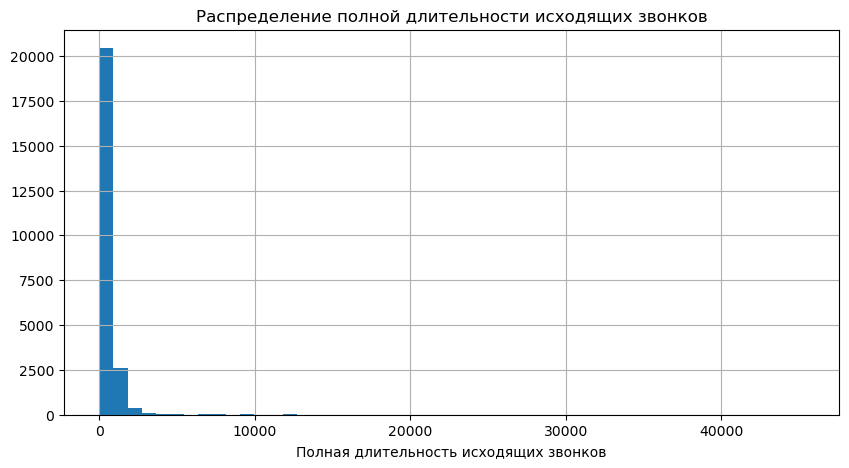

In [26]:
data.query('direction == "out"')['total_call_duration'].hist(bins=50, figsize=(10, 5))
plt.title('Распределение полной длительности исходящих звонков')
plt.xlabel('Полная длительность исходящих звонков')
plt.show()

In [27]:
data.query('direction == "out"')['total_call_duration'].describe()

count    23735.000000
mean       457.907226
std       1222.199335
min          0.000000
25%         40.000000
50%        163.000000
75%        534.000000
max      45312.000000
Name: total_call_duration, dtype: float64

Имеются выбросы. Также отбросим данные с полной длительностью исходящих вызовов выше 1320 минут.

In [28]:
data.shape[0]

41589

In [29]:
data = data.loc[((data['total_call_duration'] < 1320) & (data['direction'] == "out")) | (data['direction'] == "in")]
print('Удалили {} строк ({}%)'.format((41589-data.shape[0]), round((41589-data.shape[0])/41589*100, 1)))

Удалили 1529 строк (3.7%)


**Вывод:** Почистили данные от аномально длинных звонков за день. Определили, что данные о длительности звонков представлены в минутах.

### Количество клиентов и операторов

In [30]:
print('Количество уникальных колл-центров: {}'.format(data['user_id'].nunique()))
print('Количество уникальных операторов: {}'.format(data['operator_id'].nunique()))

Количество уникальных колл-центров: 307
Количество уникальных операторов: 1088


Посмотрим на рапределение количества операторов по колл-центрам.

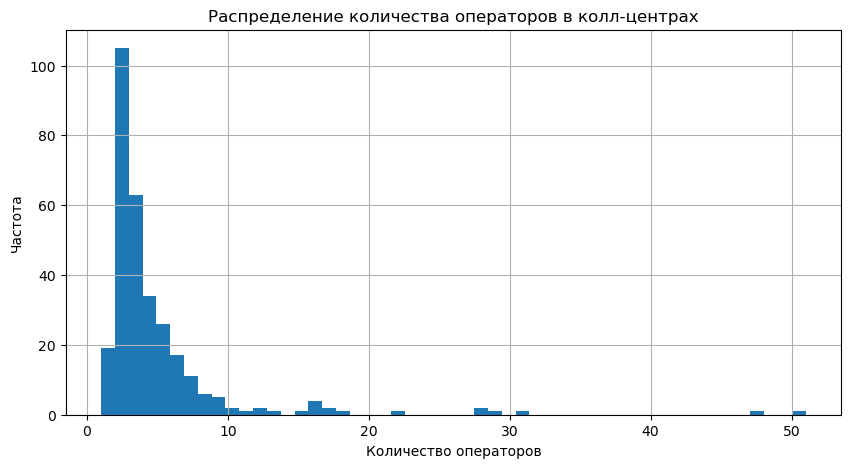

In [31]:
(
    data
    .groupby('user_id')
    .agg({'operator_id': 'nunique'})
    .hist(bins=51, figsize=(10, 5))
)
plt.title('Распределение количества операторов в колл-центрах')
plt.xlabel('Количество операторов')
plt.ylabel('Частота')
plt.show()

In [32]:
data.groupby('user_id').agg({'operator_id': 'nunique'}).describe()

,operator_id
count,307.000000
mean,4.534202
std,5.576676
min,1.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,51.000000


**Вывод:** Половина колл-центров имеет в штате не более трёх операторов, 75% колл-центров - не более пяти операторов. Максимальное количество - 51.

### Количество звонков по дням

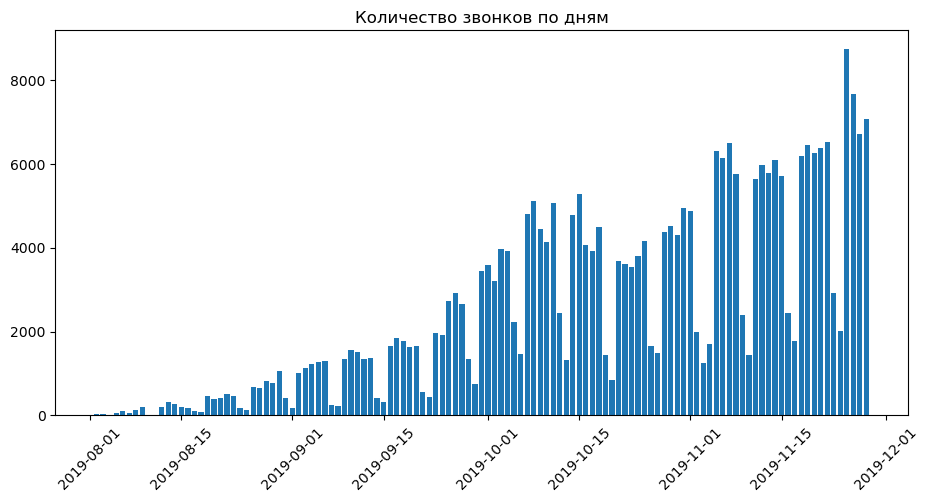

In [33]:
daily_calls = (
    data
    .groupby('date')
    .agg({'calls_count': 'sum'})
    .reset_index()
)
daily_calls.columns = ['date', 'all']
plt.figure(figsize=(11, 5))
plt.title('Количество звонков по дням')
plt.bar(x=daily_calls['date'], height=daily_calls['all'])
plt.xticks(rotation=45)
plt.show()

Наблюдается постепенный рост количества звонков. Возможно, в начале периода собирались не все данные.

Также на графиках наблюдаются резкие спады количества звонков в определённые дни. Предположим, что это происходит в выходные дни. Добавим в датафрейм столбец с номером дня недели и посмотрим на распределение звонков.

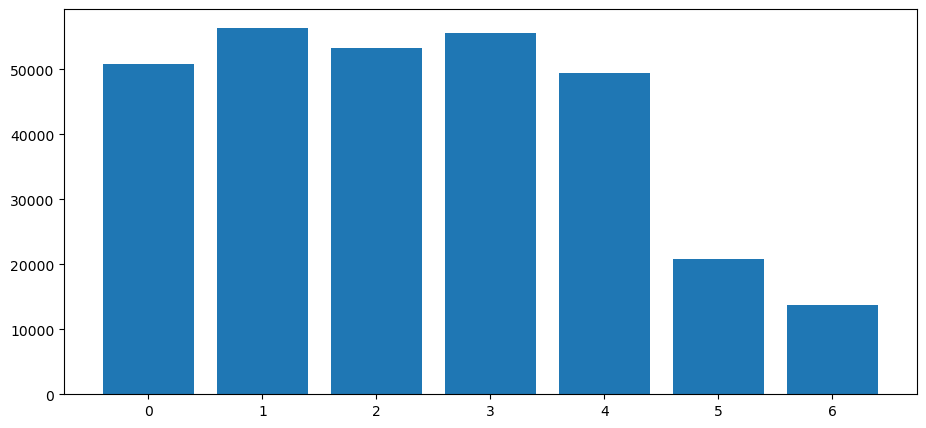

In [34]:
data['wd'] = data['date'].dt.weekday
wd_calls = (
    data
    .groupby('wd')
    .agg({'calls_count': 'sum'})
    .reset_index()
)
plt.figure(figsize=(11, 5))
plt.bar(x=wd_calls['wd'], height=wd_calls['calls_count'])
plt.show()

**Вывод:** В субботу и воскресенье значительно меньше звонков. Значит, в выходные дни работает меньше операторов либо часть колл-центров полностью на пятидневке.

Количество звонков в день постепенно растёт - возможно, в начале периода собирались не все данные.

### Доля входящих и исходящих вызовов от общего количества звонков

Посмотрим на соотношение количества исходящих и входящих вызовов к общему числу ежедневных звонков.

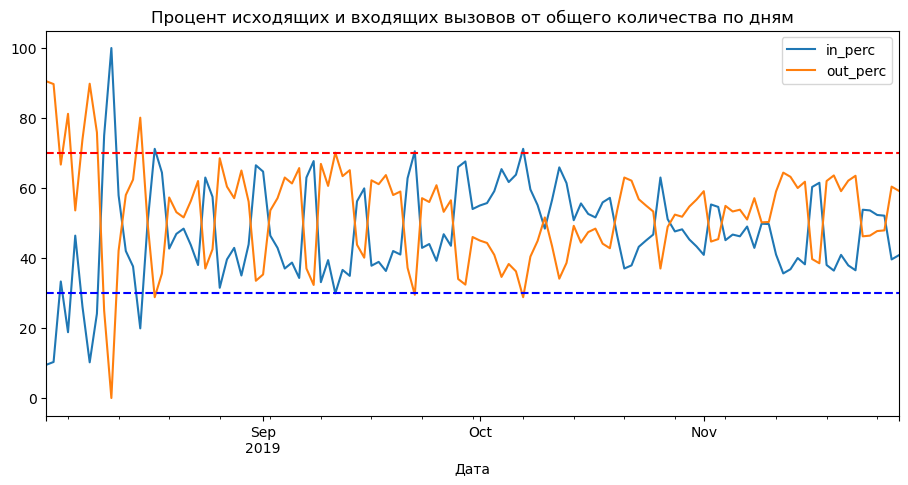

In [35]:
# ежедневное количество входящих звонков
daily_in_calls = (
    data
    .query('direction == "in"')
    .groupby('date')
    .agg({'calls_count': 'sum'})
    .reset_index()
)
daily_in_calls.columns = ['date', 'in']

# ежедневное количество исходящих звонков
daily_out_calls = (
    data
    .query('direction == "out"')
    .groupby('date')
    .agg({'calls_count': 'sum'})
    .reset_index()
)
daily_out_calls.columns = ['date', 'out']

# объединение двух таблиц с общим числом звонков и числом входящих
daily_calls = daily_calls.merge(daily_in_calls, how='left', left_on='date', right_on='date')
daily_calls = daily_calls.fillna(0)
# процент входящих от общего количества звонков
daily_calls['in_perc'] = round(daily_calls['in'] / daily_calls['all'] * 100, 1)

# присоединяем табоицу с исходящими звонками
daily_calls = daily_calls.merge(daily_out_calls, how='left', left_on='date', right_on='date')
daily_calls = daily_calls.fillna(0)
# процент исходящих
daily_calls['out_perc'] = round(daily_calls['out'] / daily_calls['all'] * 100, 1)
daily_calls = daily_calls.set_index('date')

# график процентов исходящих и входящих по дням
daily_calls[['in_perc', 'out_perc']].plot(figsize=(11, 5))
plt.axhline(y=70, color='red', linestyle='--')
plt.axhline(y=30, color='blue', linestyle='--')
plt.title('Процент исходящих и входящих вызовов от общего количества по дням')
plt.xlabel('Дата')
plt.show();

**Вывод:** Доли исходящих и входящих вызовов колеблются в диапазоне 30-70%. Нет явного преобладания одного типа звонков.

### Обзванивающие и принимающие колл-центры

Для определения эффективности сотрудников необходимо разделить колл-центры на обзванивающие и принимающие. 

Для этого:
- исключим внутренние звонки
- сгруппируем данные по id клиента и посчитаем общее количество звонков, количество входящих и исходящих звонков и их процент относительно общего количества вызовов
- примем, что для обзванивающих КЦ процент исходящих вызовов больше 50, а для принимающих процент входящих вызовов больше 50
- разделим данные на два датафрейма с разными типами колл-центров.

In [36]:
# отфильтруем только входящие внешние звонки и посчитаем их количество для каждого колл-центра
data_in = (
    data
    .query('internal == False and direction == "in"')
    .groupby('user_id')
    .agg({'calls_count': 'sum'})
    .reset_index()
)
data_in.columns = ['user_id', 'in']

# то же самое сделаем для внешних исходящих звонков
data_out = (
    data
    .query('internal == False and direction == "out"')
    .groupby('user_id')
    .agg({'calls_count': 'sum'})
    .reset_index()
)
data_out.columns = ['user_id', 'out']

# посчитаем общее количество внешних звонков для всех колл-центров
data_all = data.query('internal == False').groupby('user_id').agg({'calls_count': 'sum'}).reset_index()
data_all.columns = ['user_id', 'all']

# объединим все три таблицы и посчитаем процент входящих и исходящих звонков от общего числа
data_cc_type = data_all.merge(data_in, how='left', left_on='user_id', right_on='user_id')
data_cc_type = data_cc_type.fillna(0)
data_cc_type['in_perc'] = round(data_cc_type['in'] / data_cc_type['all'] * 100, 1)

data_cc_type = data_cc_type.merge(data_out, how='left', left_on='user_id', right_on='user_id')
data_cc_type = data_cc_type.fillna(0)
data_cc_type['out_perc'] = round(data_cc_type['out'] / data_cc_type['all'] * 100, 1)

# примем, что для принимающих КЦ процент входящих звонков > 50, для обзванивающих КЦ процент исходящих звонков > 50
# создадим списки с обзванивающими и принимающими КЦ
cc_in = data_cc_type.query('in_perc > 50')['user_id']
cc_out = data_cc_type.query('out_perc > 50')['user_id']

# создадим два датафрейма для обзванивающих и принимающих КЦ
data_cc_in = data.query('user_id in @cc_in')
data_cc_out = data.query('user_id in @cc_out')

### Количество и процент пропущенных звонков

Данная метрика важна для оценки эффективности операторов принимающих колл-центров, поэтому рассмотрим этот показатель только для этого типа колл-центров.

In [37]:
print('Общее количество пропущенных вызовов в принимающих колл-центрах: {}'
      .format(data_cc_in.query('is_missed_call == True and direction == "in"')['calls_count'].sum()))
print('Доля пропущенных вызовов от общего количества внешних входящих: {}%'
      .format(round(data_cc_in.query('is_missed_call == True and direction == "in"')['calls_count'].sum() / 
                    data_cc_in.query('direction == "in"')['calls_count'].sum() * 100, 1)))

Общее количество пропущенных вызовов в принимающих колл-центрах: 86739
Доля пропущенных вызовов от общего количества внешних входящих: 81.5%


Более 80% вызовов пропущены.

Рассмотрим распределение доли пропущенных вызовов по операторам.

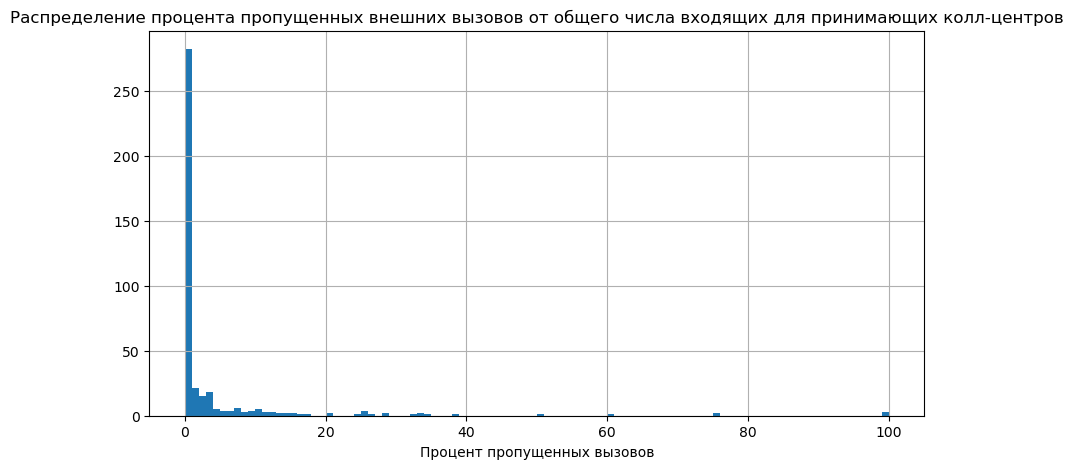

In [38]:
# количество пропущенных звонков по операторам
op_missed_calls = (
    data_cc_in
    .query('is_missed_call == True and direction == "in"')
    .groupby('operator_id')
    .agg({'calls_count': 'sum'})
    .reset_index()
)
op_missed_calls.columns = ['operator_id', 'missed_calls']

# общее количество входящих звонков по операторам
op_all_calls = (
    data_cc_in
    .query('direction == "in"')
    .groupby('operator_id')
    .agg({'calls_count': 'sum'})
    .reset_index()
)
op_all_calls.columns = ['operator_id', 'all_calls']

# объединение двух таблиц
op_in_calls = op_all_calls.merge(op_missed_calls, how='left', left_on='operator_id', right_on='operator_id')
op_in_calls = op_in_calls.fillna(0)
# рассчёт процента пропущенных
op_in_calls['missed_perc'] = round(op_in_calls['missed_calls'] / op_in_calls['all_calls'] * 100, 1)

# распределение процента пропущенных
op_in_calls['missed_perc'].hist(bins=100, figsize=(10, 5))
plt.title('Распределение процента пропущенных внешних вызовов от общего числа входящих для принимающих колл-центров')
plt.xlabel('Процент пропущенных вызовов')
plt.show()

In [39]:
op_in_calls['missed_perc'].describe()

count    403.000000
mean       3.814144
std       12.062772
min        0.000000
25%        0.000000
50%        0.000000
75%        1.850000
max      100.000000
Name: missed_perc, dtype: float64

In [40]:
op_in_calls.query('missed_perc == 100')

,operator_id,all_calls,missed_calls,missed_perc
0,1,86152,86112.0,100.0
183,919204,9,9.0,100.0
184,919206,9,9.0,100.0


Больше половины операторов не имеет пропущенных вызовов. Есть два оператора, пропустивших все звонки, а также неопределённые операторы.

**Вывод:**
Более 80% всех внешних входящих вызовов в принимающих колл-центрах пропущены.

Больше половины операторов не имеет пропущенных вызовов. Есть два оператора, пропустивших все звонки, а также неопределённые операторы. Кто-то явно портит статистику.

### Количество исходящих звонков

Данная метрика важна для оценки эффективности операторов обзванивающих колл-центров, поэтому проведём рассчёты для этого типа.

Возьмём данные об исходящих внешних вызовах.

In [41]:
print('Общее количество исходящих внешних вызовов в обзванивающих колл-центрах: {}'
      .format(data_cc_out.query('direction == "out" and internal == False')['calls_count'].sum()))

Общее количество исходящих внешних вызовов в обзванивающих колл-центрах: 104557


Посмотрим распределение количества исходящих звонков в обзванивающих колл-центрах.

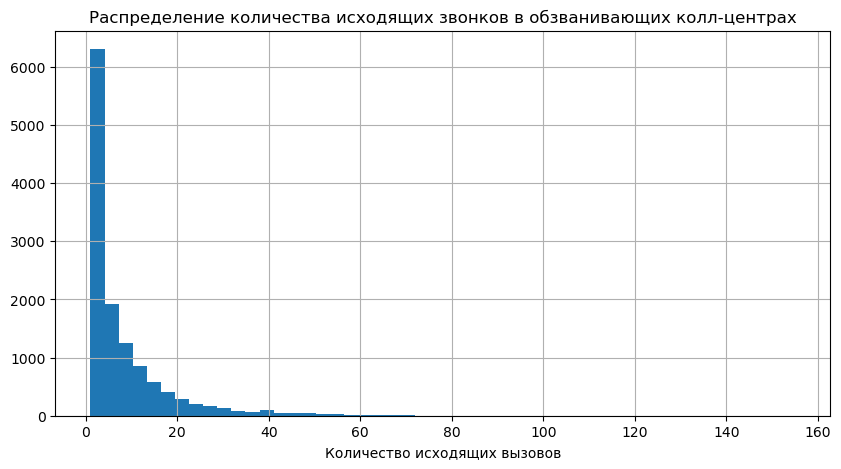

In [42]:
data_cc_out.query('direction == "out" and internal == False')['calls_count'].hist(bins=50, figsize=(10, 5))
plt.title('Распределение количества исходящих звонков в обзванивающих колл-центрах')
plt.xlabel('Количество исходящих вызовов')
plt.show()

In [43]:
data_cc_out.query('direction == "out" and internal == False')['calls_count'].describe()

count    12619.000000
mean         8.285680
std         10.306882
min          1.000000
25%          2.000000
50%          5.000000
75%         10.000000
max        155.000000
Name: calls_count, dtype: float64

**Вывод:** Половина работников делает не более 5 исходящих внешних вызовов в день!

### Время ожидания

Данная метрика важна для принимающих колл-центров.

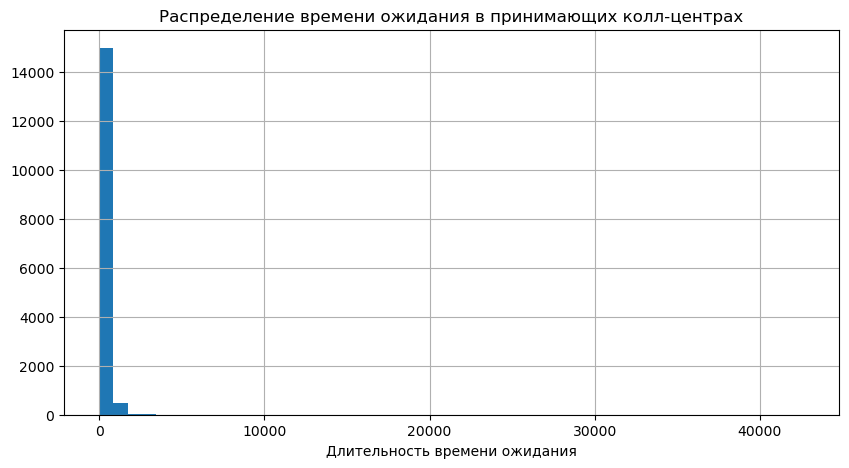

In [44]:
data_cc_in['waiting'].hist(bins=50, figsize=(10, 5))
plt.title('Распределение времени ожидания в принимающих колл-центрах')
plt.xlabel('Длительность времени ожидания')
plt.show()

In [45]:
data_cc_in['waiting'].describe()

count    15527.000000
mean       134.219038
std        591.834388
min          0.000000
25%         12.000000
50%         32.000000
75%         93.000000
max      42667.000000
Name: waiting, dtype: float64

**Вывод:** Здесь есть аномальные значения, но звонки на ожидании могут идти одновременно и время ожидания накладывается друг на друга.

## Определение неэффективных операторов

Признаки неэффективности операторов колл-центров:
- много пропущенных входящих звонков;
- долгое ожидание ответа при входящих вызовах;
- мало исходящих звонков - для колл-центров, специализирующихся на обзвонах.
    
Определим пороги эффективности - количество (процент) пропущенных звонков, длительность ожидания ответа и количество исходящих вызовов, при которых оператора можно считать неэффективным.

Для процента пропущенных звонков примем, что для КЦ допустимо 5% пропущенных вызовов. Поделим 5% на количество операторов КЦ - это и будет порог эффективности для операторов данного КЦ.

Для длительности ожидания ответа в качестве порога возьмём среднее значение времени ожидания одного пропущенного звонка.

Для количества исходящих вызовов категоризуем КЦ по длительности рабочего дня и по длительности одного звонка. Исходя из этих данных определим для каждого КЦ необходимое количество звонков - это и будет порогом критерия эффективности.

Далее сформируем список колл-центров с большим количеством неэффективных сотрудников.

### Принимающие КЦ

Для принимающих КЦ важны два показателя - процент пропущенных входящих вызовов и длительность времени ожидания. Определим списки неэффективных операторов для каждого показателя, а затем выделим неуспешных операторов одновременно для двух показателей.

#### Пропущенные входящие вызовы

Установим, что для принимающих КЦ допустимо 5% пропущенных звонков. Исходя из этого определим неэффективных операторов по этому показателю.

Для начала посчитаем допустимый процент пропущенных вызовов для каждого оператора принимающего КЦ - допустимые для всего колл-центра 5% разделим на количество операторов в нём.

In [46]:
# количество операторов в КЦ
cc_in_all_calls = (
    data_cc_in
    .query('direction == "in"')
    .groupby('user_id')
    .agg({'operator_id': 'nunique'})
    .reset_index()
)
cc_in_all_calls.columns = ['user_id', 'op_count']

# вычислим допустимый процент пропущенных на каждого оператора: 5% на каждый КЦ поделим на количество операторов
cc_in_all_calls['allowed_missed_perc'] = round(5 / cc_in_all_calls['op_count'], 2)

Далее для каждого оператора каждого колл-центра вычислим процент пропущенных вызовов.

In [47]:
# общее количество звонков по операторам колл-центров
cc_in_op_all_calls = (
    data_cc_in
    .query('direction == "in"')
    .groupby(['user_id', 'operator_id'])
    .agg({'calls_count': 'sum'})
    .reset_index()
)
cc_in_op_all_calls.columns = ['user_id', 'operator_id', 'op_all_calls']

# количество пропущенных по операторам колл-центров
cc_in_op_missed_calls = (
    data_cc_in
    .query('direction == "in" and is_missed_call == True')
    .groupby(['user_id', 'operator_id'])
    .agg({'calls_count': 'sum'})
    .reset_index()
)
cc_in_op_missed_calls.columns = ['user_id', 'operator_id', 'op_missed_calls']

# объединение
cc_in_op_missed_perc = (
    cc_in_op_all_calls
    .merge(cc_in_op_missed_calls, how='left', left_on=['user_id', 'operator_id'], right_on=['user_id', 'operator_id'])
)
cc_in_op_missed_perc = cc_in_op_missed_perc.fillna(0)

# вычисление процента пропущенных вызовов на каждого оператора колл-центра
cc_in_op_missed_perc['op_missed_perc'] = round(
    cc_in_op_missed_perc['op_missed_calls'] / cc_in_op_missed_perc['op_all_calls'] * 100, 1
)

Объединим две таблицы с допустимыми значениями доли пропущенных вызовов и реальными значениями доли пропущенных вызовов по операторам. После этого сравним допустимые и реальные значения и выделим неэффективных по пропущенным вызовам операторов.

In [48]:
# объединим таблицы со статистикой по КЦ и по операторам КЦ
cc_in_fin = cc_in_op_missed_perc.merge(cc_in_all_calls, how='left', left_on='user_id', right_on='user_id')
# список неэффективных по пропущенным вызовам операторов
op_many_missed_calls = cc_in_fin.query('op_missed_perc > allowed_missed_perc')['operator_id'].unique()

In [49]:
print('Выявили {} неэффективных операторов ({}%)'
      .format(len(op_many_missed_calls), 
              round(len(op_many_missed_calls) / cc_in_fin['operator_id'].nunique() * 100, 1))
     )

Выявили 111 неэффективных операторов (27.5%)


#### Время ожидания

Для принимающих колл-центров важно. чтобы время ожидания звонящих не было слишком долгим. Для определения порога эффективности операторов по времени ожидания определим, при каком времени ожидания звонящие кладут трубку - разделим дневное время ожидания на количество звонков в день.

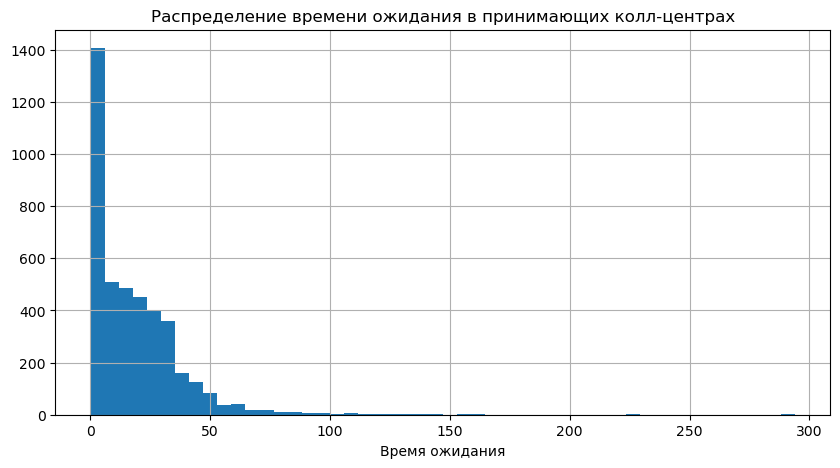

In [50]:
waiting = (
    data_cc_in.query('direction == "in" and internal == False and is_missed_call == True')['waiting'] / 
    data_cc_in.query('direction == "in" and internal == False and is_missed_call == True')['calls_count']
)
waiting.hist(bins=50, figsize=(10, 5))
plt.title('Распределение времени ожидания в принимающих колл-центрах')
plt.xlabel('Время ожидания')
plt.show()

In [51]:
waiting.describe()

count    4160.000000
mean       18.124359
std        19.235718
min         0.000000
25%         2.250000
50%        14.000000
75%        27.257812
max       294.000000
dtype: float64

**В качестве порога времени ожидания одного вызова возьмём среднее значение - 18.1 минуты**. Исходя из этого составим список неэффективных по времени ожидания операторов принимающих колл-центров.

В отличие от перцентилей и медианы среднее значение в качестве порога не будет отсекать определённый процент данных при любых условиях работы операторов.

In [52]:
waiting_uneffective = (
    data_cc_in
    .loc[(data_cc_in['waiting'] / data_cc_in['calls_count']) > 18.1]['operator_id']
    .unique()
    .tolist()
)
print('Выявлено {} неэффективных по времени ожидания операторов принимающих КЦ ({}%)'
      .format(len(waiting_uneffective), 
      round(len(waiting_uneffective) / data_cc_in['operator_id'].nunique() * 100, 1)))

Выявлено 407 неэффективных по времени ожидания операторов принимающих КЦ (77.5%)


Для создания итогового списка неэффективных операторов принимающих КЦ найдём совпадения по двум спискам с неэффективными операторами по двум критериям.

In [53]:
def intersection_list(list1, list2):
    list3 = [value for value in list1 if value in list2] 
    return list3 
 
in_uneff_op = intersection_list(waiting_uneffective, op_many_missed_calls)
print('Количество неэффективных операторов принимающих КЦ: {} ({}%)'
      .format(len(in_uneff_op), round(len(in_uneff_op) / data_cc_in['operator_id'].nunique() * 100, 1)))

Количество неэффективных операторов принимающих КЦ: 104 (19.8%)


### Обзванивающие КЦ - количество исходящих вызовов

В разных КЦ могут быть рабочие смены разной длительности. Попробуем категоризовать кц по этому признаку. Сгруппируем данные по кц и определим среднее значение полного времени разговора.

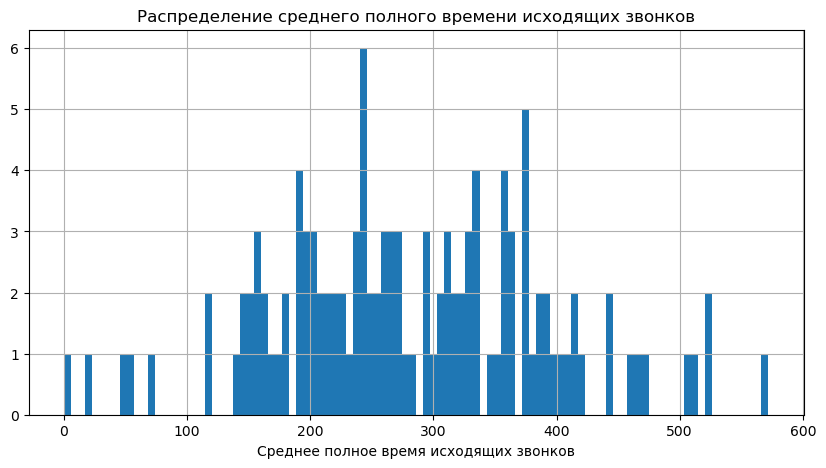

In [54]:
cc_mean_time = (
    data_cc_out
    .query('direction == "out"')
    .groupby('user_id')
    .agg({'total_call_duration': 'mean'})
)
cc_mean_time.hist(bins=100, figsize=(10, 5))
plt.title('Распределение среднего полного времени исходящих звонков')
plt.xlabel('Среднее полное время исходящих звонков')
plt.show()

Выделим следующие категории КЦ по среднему полному времени исходящего звонка:
- от 0 до 180
- от 180 до 290
- от 290 до 400
- выше 400.

In [55]:
cc_mean_time = cc_mean_time.reset_index()
cc_mean_time.columns = ['user_id', 'mean_time']

def cat_cc(row):
    if row['mean_time'] <= 180:
        return 'A'
    elif row['mean_time'] <= 290:
        return 'B'
    elif row['mean_time'] <= 400:
        return 'C'
    elif row['mean_time'] > 400:
        return 'D'
    
cc_mean_time['category'] = cc_mean_time.apply(cat_cc, axis=1)

Определим для каждой категории среднее значение длительности рабочей смены - учтём 20% бездействия и 1 обеденный час.

In [56]:
cat_mean_work_day = (
    cc_mean_time
    .groupby('category')
    .agg({'mean_time': 'mean'})
    .reset_index()
)
cat_mean_work_day.columns = ['category', 'work_day']
cat_mean_work_day['work_day'] = round(cat_mean_work_day['work_day'] / 0.8 + 60)

Объединим два датафрейма со средними значениями каждого КЦ и средними значениями по категориям.

In [57]:
cc_out_cat = cc_mean_time.merge(cat_mean_work_day, how='left', left_on='category', right_on='category')
cc_out_cat.head()

,user_id,mean_time,category,work_day
0,166377,283.801444,B,351.0
1,166406,363.046632,C,490.0
2,166407,116.301136,A,216.0
3,166485,308.549161,C,490.0
4,166487,329.437500,C,490.0


Надо разбить КЦ на категории по средней длительности одного звонка. Делим длительность звонков на их количество - получаем среднюю длительность звонка каждого кц. Далее категоризуем по диапазонам и выводим среднее среднего.

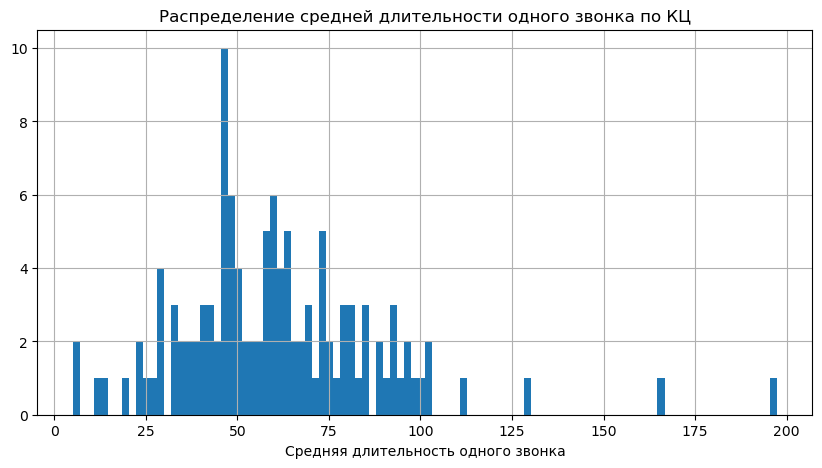

In [58]:
data_cc_out['one_call_dur'] = round(data_cc_out['total_call_duration'] / data_cc_out['calls_count'])
out_one_call = data_cc_out.groupby('user_id').agg({'one_call_dur': 'mean'}).reset_index()

out_one_call['one_call_dur'].hist(bins=100, figsize=(10, 5))
plt.title('Распределение средней длительности одного звонка по КЦ')
plt.xlabel('Средняя длительность одного звонка')
plt.show()

Разобьём КЦ на следующие категории по длительности одного звонка:
- до 30
- от 30 до 60
- от 60 до 90
- выше 90

In [59]:
def cat_cc_one_call(row):
    if row['one_call_dur'] <= 30:
        return 'W'
    elif row['one_call_dur'] <= 60:
        return 'X'
    elif row['one_call_dur'] <= 90:
        return 'Y'
    elif row['one_call_dur'] > 90:
        return 'Z'
    
out_one_call['cat_one_call'] = out_one_call.apply(cat_cc_one_call, axis=1)

Для каждой категории определим среднюю длительность одного вызова.

In [60]:
cat_one_call_avg = (
    out_one_call
    .groupby('cat_one_call')
    .agg({'one_call_dur': 'mean'})
    .reset_index()
)
cat_one_call_avg.columns=['cat_one_call', 'avg_cat_one_call_dur']
cat_one_call_avg['avg_cat_one_call_dur'] = round(cat_one_call_avg['avg_cat_one_call_dur'])
cat_one_call_avg

,cat_one_call,avg_cat_one_call_dur
0,W,21.0
1,X,48.0
2,Y,73.0
3,Z,111.0


Объединим два дф со средними значениями длительности по каждому кц и по категориям.

In [61]:
out_one_call_dur = out_one_call.merge(cat_one_call_avg, how='left', left_on='cat_one_call', right_on='cat_one_call')
out_one_call_dur.head()

,user_id,one_call_dur,cat_one_call,avg_cat_one_call_dur
0,166377,49.188630,X,48.0
1,166406,50.882353,X,48.0
2,166407,68.640449,Y,73.0
3,166485,73.474124,Y,73.0
4,166487,51.809524,X,48.0


Объединим два дф со средними значениями длительности одного звонка и длительностью рабочего дня.

In [62]:
cc_out_2 = cc_out_cat.merge(out_one_call_dur, how='left', left_on='user_id', right_on='user_id')

Определим необходимое количество звонков для разных категорий кц - разделим длину рабочей смены на среднюю длительность одного звонка.

In [63]:
cc_out_2['needed_calls'] = round(cc_out_2['work_day'] / cc_out_2['avg_cat_one_call_dur'])
cc_out_2.head()

,user_id,mean_time,category,work_day,one_call_dur,cat_one_call,avg_cat_one_call_dur,needed_calls
0,166377,283.801444,B,351.0,49.188630,X,48.0,7.0
1,166406,363.046632,C,490.0,50.882353,X,48.0,10.0
2,166407,116.301136,A,216.0,68.640449,Y,73.0,3.0
3,166485,308.549161,C,490.0,73.474124,Y,73.0,7.0
4,166487,329.437500,C,490.0,51.809524,X,48.0,10.0


Объединим два дф с необходимым количеством звонков и с данными по звонкам всех операторов обзванивающих КЦ.

In [64]:
cc_out_3 = data_cc_out.merge(cc_out_2, how='left', left_on='user_id', right_on='user_id')
cc_out_3 = cc_out_3[[
    'user_id',
    'direction',
    'operator_id',
    'calls_count',
    'needed_calls'
]]
cc_out_3.head()

,user_id,direction,operator_id,calls_count,needed_calls
0,166377,in,1,2,7.0
1,166377,out,880022,3,7.0
2,166377,out,880020,1,7.0
3,166377,out,880020,1,7.0
4,166377,out,880022,3,7.0


Сравним реальное и необходимое количество звонков и определим неэффективных операторов.

In [65]:
out_calls_uneffective_op = (
    cc_out_3
    .query('direction == "out" and calls_count < needed_calls')['operator_id']
    .unique()
    .tolist()
)
print('Выявили {} неэффективных операторов обзванивающих КЦ ({}%)'
     .format(len(out_calls_uneffective_op), 
             round(len(out_calls_uneffective_op) / cc_out_3['operator_id'].nunique() * 100, 1)))

Выявили 502 неэффективных операторов обзванивающих КЦ (89.5%)


**Вывод:** Получился очень высокий процент неэффективных операторов - лишь 10% сотрудников выполняют работу качественно.

### КЦ с неэффективными операторами

Отберём принимающие КЦ с неэффективными операторами.

Посчитаем количество неэффективных операторов для каждого кц.

In [66]:
in_cc_unef = (
    data_cc_in
    .query('operator_id in @in_uneff_op')
    .groupby('user_id')
    .agg({'operator_id': 'nunique'})
    .sort_values('operator_id', ascending=False)
    .reset_index()
)
in_cc_unef.columns = ['user_id', 'unef_op_count']
in_cc_unef.head()

,user_id,unef_op_count
0,168252,11
1,166916,9
2,166405,8
3,167977,6
4,167445,6


Посчитаем количество всех операторов по КЦ.

In [67]:
in_all_op = (
    data_cc_in
    .groupby('user_id')
    .agg({'operator_id': 'nunique'})
    .reset_index()
)
in_all_op.columns = ['user_id', 'all_op_count']

Объединим два датафрейма и посчитаем процент неэффективных операторов. Посмотрим на распределение процента неэффективных операторов.

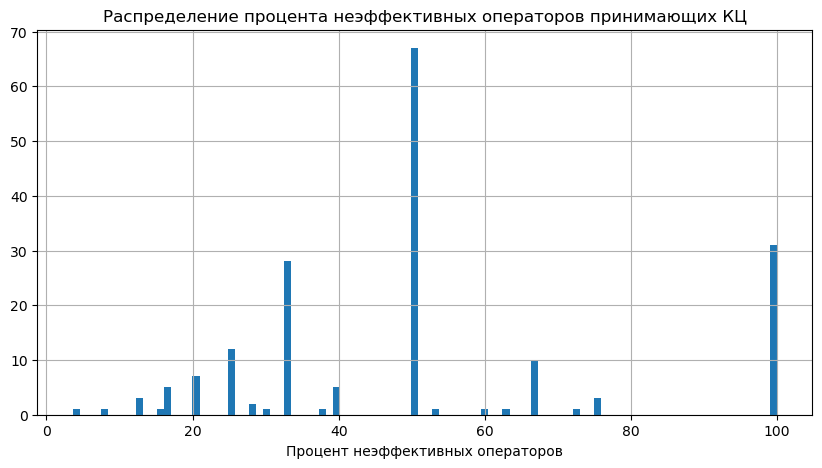

In [68]:
in_unef_perc = in_all_op.merge(in_cc_unef, how='inner', left_on='user_id', right_on='user_id')
in_unef_perc['unef_perc'] = round(in_unef_perc['unef_op_count'] / in_unef_perc['all_op_count'] * 100, 1)
in_unef_perc['unef_perc'].hist(bins=100, figsize=(10, 5))
plt.title('Распределение процента неэффективных операторов принимающих КЦ')
plt.xlabel('Процент неэффективных операторов')
plt.show()

Примем, что обычный уровень неэффективности для КЦ 5-30%. Более высокий процент говорит о том. что операторы и аппаратура не справляются с нагрузкой и имеются технические неполадки. Сформируем список принимающих КЦ (с долей неэффективных операторов 5-30%), которым можно предложить услугу по установке программного обеспечения для определения неэффективных операторов.

In [69]:
cc_in_recommend = in_unef_perc.query('unef_perc >= 5 and unef_perc <= 30')['user_id'].unique().tolist()
print('Количество возможных клиентов новой услуги: {}'.format(len(cc_in_recommend)))

Количество возможных клиентов новой услуги: 32


Отберём обзванивающие КЦ с неэффективными операторами.

Посчитаем количество неэффективных операторов для каждого кц.

In [70]:
out_cc_unef = (
    data_cc_out
    .query('operator_id in @out_calls_uneffective_op')
    .groupby('user_id')
    .agg({'operator_id': 'nunique'})
    .sort_values('operator_id', ascending=False)
    .reset_index()
)
out_cc_unef.columns = ['user_id', 'unef_op_count']
out_cc_unef.head()

,user_id,unef_op_count
0,168187,43
1,167497,29
2,168062,28
3,166680,19
4,168091,17


Посчитаем количество всех операторов по КЦ.

In [71]:
out_all_op = (
    data_cc_out
    .groupby('user_id')
    .agg({'operator_id': 'nunique'})
    .reset_index()
)
out_all_op.columns = ['user_id', 'all_op_count']

Объединим два датафрейма и посчитаем процент неэффективных операторов. Посмотрим на распределение процента неэффективных операторов.

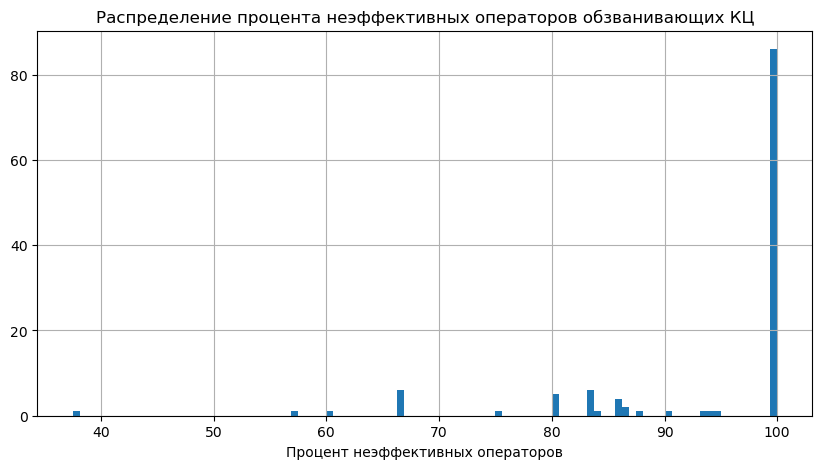

In [72]:
out_unef_perc = out_all_op.merge(out_cc_unef, how='inner', left_on='user_id', right_on='user_id')
out_unef_perc['unef_perc'] = round(out_unef_perc['unef_op_count'] / out_unef_perc['all_op_count'] * 100, 1)
out_unef_perc['unef_perc'].hist(bins=100, figsize=(10, 5))
plt.title('Распределение процента неэффективных операторов обзванивающих КЦ')
plt.xlabel('Процент неэффективных операторов')
plt.show()

Исходя из логики выше сформируем рекомендуемый список КЦ, но увеличим значение доли неэффективных операторов до 40, так как у большинства обзванивающих КЦ этот показатель очень высок.

In [73]:
cc_out_recommend = out_unef_perc.query('unef_perc < 50')['user_id'].unique().tolist()
print('Количество возможных клиентов новой услуги: {}'.format(len(cc_out_recommend)))

Количество возможных клиентов новой услуги: 1


**Вывод:** Сформировали списки потенциальных клиентов новой услуги по определению неэффективных операторов - 32 принимающих КЦ и 1 обзванивающий КЦ.

## Проверка статистических гипотез

### Гипотеза 1

Сформируем нулевую и альтернативную статистические гипотезы:
```
H_0: Средний процент пропущенных маленьких КЦ = средний процент пропущенных больших КЦ
H_a: Средний процент пропущенных маленьких КЦ ≠ средний процент пропущенных больших КЦ
alpha = 0.05
```

и проведём проверку.

Разделим принимающие КЦ на большие и маленькие.

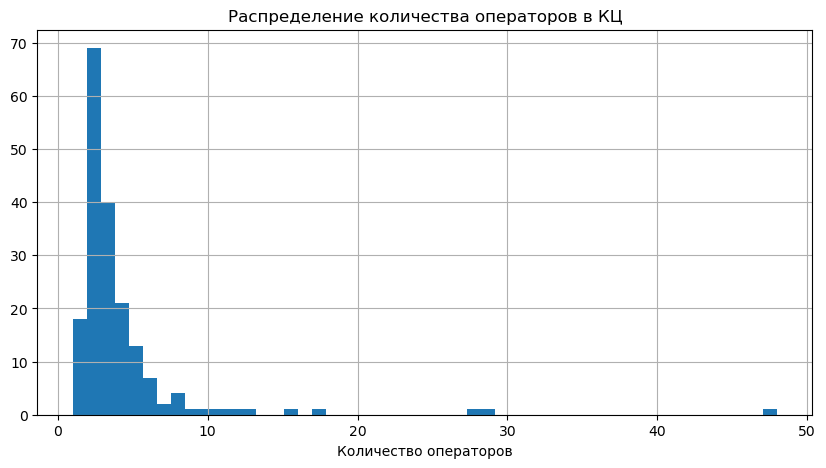

In [74]:
in_op_count = data_cc_in.groupby('user_id').agg({'operator_id': 'nunique'})
in_op_count.hist(bins=50, figsize=(10, 5))
plt.title('Распределение количества операторов в КЦ')
plt.xlabel('Количество операторов')
plt.show()

In [75]:
in_op_count.describe()

,operator_id
count,184.000000
mean,3.836957
std,4.848023
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,48.000000


Среднее число операторов в КЦ - 4. Примем, что в маленьких КЦ не больше 4 операторов, в больших - больше 4.

In [76]:
in_op_count = in_op_count.reset_index()
in_op_count.columns = ['user_id', 'op_count']

small_cc_list = in_op_count.query('op_count <= 4')['user_id'].tolist()
big_cc_list = in_op_count.query('op_count > 4')['user_id'].tolist()

small_in_cc = cc_in_op_missed_perc.query('user_id in @small_cc_list')
big_in_cc = cc_in_op_missed_perc.query('user_id in @big_cc_list')

In [77]:
small_missed_perc = small_in_cc['op_missed_perc']
big_missed_perc = big_in_cc['op_missed_perc']
alpha = 0.05

results = st.mannwhitneyu(small_missed_perc, big_missed_perc)
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  5.2768438802780716e-06
Отвергаем нулевую гипотезу: разница статистически значима


**Вывод:** Есть существенное различие в среднем проценте пропущенных звонков в маленьких и больших КЦ. Значит, нужно более детально проработать пороги эффективности операторов по доле пропущенных вызовов - для больших и маленьких КЦ эти пороги будут отличаться.

### Гипотеза 2

Сформируем нулевую и альтернативную статистические гипотезы:
```
H_0: Среднее время ожидания одного звонка маленьких КЦ = среднее время ожидания одного звонка больших КЦ
H_a: Среднее время ожидания одного звонка маленьких КЦ ≠ среднее время ожидания одного звонка больших КЦ
alpha = 0.05
```

и проведём проверку.

In [78]:
small_in_waiting_cc = data_cc_in.query('user_id in @small_cc_list')
big_in_waiting_cc = data_cc_in.query('user_id in @big_cc_list')

small_in_waiting_cc['one_waiting'] = small_in_waiting_cc['waiting'] / small_in_waiting_cc['calls_count']
big_in_waiting_cc['one_waiting'] = big_in_waiting_cc['waiting'] / big_in_waiting_cc['calls_count']

In [79]:
small_waiting = small_in_waiting_cc['one_waiting']
big_waiting = big_in_waiting_cc['one_waiting']
alpha = 0.05

results = st.mannwhitneyu(small_waiting, big_waiting)
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  0.003885391017050764
Отвергаем нулевую гипотезу: разница статистически значима


**Вывод:** Есть существенное различие в среднем времени ожидания одного звонка в маленьких и больших КЦ. Значит, для маленьких и больших КЦ нужны будут разные пороги эффективности по времени ожидания.

## Выводы и рекомендации

В ходе исследования были сделаны следующие выводы:
- Имеются данные за 4 неполных месяца со 2 августа по 28 ноября 2019 года.
- Данные о длительности звонков представлены в минутах.
- В субботу и воскресенье значительно меньше звонков. Значит, в выходные дни работает меньше операторов либо часть колл-центров полностью на пятидневке.
- Количество звонков в день постепенно растёт - возможно, в начале периода собирались не все данные.
- Доли исходящих и входящих вызовов колеблются в диапазоне 30-70%. Нет явного преобладания одного типа звонков.
- Половина колл-центров имеет в штате не более трёх операторов, 75% колл-центров - не более пяти операторов. Максимальное количество - 51.
- Данные поделены на принимающие и обзванивающие КЦ.
- Более 80% всех внешних входящих вызовов в принимающих колл-центрах пропущены.
- Половина работников делает не более 5 исходящих внешних вызовов в день.
- Больше половины операторов не имеет пропущенных вызовов. 
- Есть два оператора, пропустивших все звонки, а также неопределённые операторы. Кто-то явно портит статистику.
- Определены критерии эффективности операторов и их пороги:
```
Для процента пропущенных звонков примем, что для КЦ допустимо 5% пропущенных вызовов. Поделим 5% на количество операторов КЦ - это и будет порог эффективности для операторов данного КЦ.
Для длительности ожидания ответа в качестве порога возьмём среднее значение времени ожидания одного пропущенного звонка.
Для количества исходящих вызовов категоризуем КЦ по длительности рабочего дня и по длительности одного звонка. Исходя из этих данных определим для каждого КЦ необходимое количество звонков - это и будет порогом критерия эффективности.
```
- Выявили 111 неэффективных по проценту пропущенных вызовов операторов (27.5%).
- Выявлено 407 неэффективных по времени ожидания операторов принимающих КЦ (77.5%).
- Итого выявлено 104 неэффективных оператора принимающих КЦ (19.8%).
- Выявлено 502 неэффективных по количеству исходящих звонков оператора обзванивающих КЦ (89.5%).
- Сформировали списки потенциальных клиентов новой услуги по определению неэффективных операторов - 32 принимающих КЦ (`cc_in_recommend`) и 1 обзванивающий КЦ (`cc_out_recommend`).
- Время ожидания одного звонка и процент пропущенных вызовов маленьких и больших принимающих КЦ сильно отличаются. Значит, для определения неэффективных операторов для маленьких и больших КЦ необходимы разные пороги неэффективности.
 
**Рекомендации заказчику:**
В ходе исследования были сформированы списки потенциальных клиентов новой услуги по определению неэффективных операторов - 32 принимающих КЦ (cc_in_recommend) и 1 обзванивающий КЦ (cc_out_recommend), рекомендуется предложить им возможную новую опцию.

[Презентация к проекту](https://drive.google.com/file/d/1-fAPi1wFHKe50djMkkz_KqLGdkAzv0XF/view?usp=sharing)

[Дашборд Tableau](https://public.tableau.com/app/profile/daria.georgieva/viz/call-centers/sheet0)